<a href="https://colab.research.google.com/github/eljimenezj/CM0868--Estadistica-Multivariada-Avanzada/blob/master/01_Clasificaci%C3%B3n_de_imagenes_skelarn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Estadistica Multivariada - Clasificación de imagenes con modelos de Machine Learning en `sklearn`

Este libro contiene un estudio de de clasificación de imagenes utilizando la libreria `sklearn` de python. Esto libro hace parte del proyecto final del curso de Estadistica Multivariada Avanzanda de la Maestría de Ciencia de Datos.

Los integrantes de este trabajo:

* Jorge Luis Renteria Roa
* Edgar Leandro Jimenez Jaimes


Vamos a instalar las librerias necesarias para la ejecución de este libro

In [33]:
# Importación libreria

import pandas as pd
import glob
import re
import numpy as np
import imutils
import time
import matplotlib.pyplot as plt
import cv2 as cv
import matplotlib.pyplot as plt


from PIL import Image
from google.colab import drive
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_validate
from sklearn.svm import SVC
from keras.preprocessing import image
from pathlib import Path
from sklearn.model_selection import GridSearchCV, train_test_split
from skimage.io import imread
from sklearn.metrics import roc_curve

from sklearn.metrics import  classification_report, confusion_matrix, accuracy_score, plot_roc_curve


import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 30*30 + 1)
print("Files imported successfully")

from collections import Counter

Files imported successfully


## Lectura de y carga de información

In [3]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Repo de Imagenes
path= '/content/drive/My Drive/Estadistica Multivariada/Proyecto Final/Dataset/datalake'

# Listas de almacenamiento
image_list=[]
tags=[]
imagemath=[]
train_img = []

# Recorrido de los archivos de imagenes
for filename in glob.glob(path+'/*'): 
  img = imread(filename)                   # Lee la imagen del datalake
  img_pred = cv.resize(img, (400, 400))    # Todas las imagenes quedan de 400 pixeles por 400 pixeles 
  img_pred = img_pred / 255                # Normalizando la imagen, cada pixel toma valores de 0 a 255.
  train_img.append(img_pred)               # Anexar la imagen a una lista
  tags.append(re.sub(path,'',filename)[1]) # Label
  image_list.append(filename)

In [5]:
# Creación de tags de las imagenes
X = np.array(train_img)
y = np.array(tags)

df = pd.DataFrame()
df['Nombre']=list(image_list)
df['Tag']=list(tags)
df['Matriz']=list(train_img)

df.head(3)                   # Mostramos los primero registro

,Nombre,Tag,Matriz
0,/content/drive/My Drive/Estadistica Multivaria...,1,"[[[0.7647058823529411, 0.7490196078431373, 0.7..."
1,/content/drive/My Drive/Estadistica Multivaria...,1,"[[[0.0784313725490196, 0.08235294117647059, 0...."
2,/content/drive/My Drive/Estadistica Multivaria...,1,"[[[0.4588235294117647, 0.3686274509803922, 0.2..."


In [6]:
# Observemos el numero de registros por clases
print(sorted(Counter(y).items()))

[('1', 57), ('2', 27)]


## Reshape y partición de datos en Train, Validation y Test

Redefiniciòn de dimensión de los arrays para entrenamiento con `sklearn`

In [7]:
# Para entrenar modelos clásicos necesitamos redefinir la dimensión de X

print("La dimensión de X que contiene las imagenes", X.shape)
 
x = np.array(train_img)
nsamples, nx, ny,channels = x.shape                    # Extracción de dimnesiónes originales
x_resh = x.reshape((nsamples,nx*ny*channels))          # Redimensionamiento

print("La nueva dimensión de X que contiene las imagenes", x_resh.shape)

La dimensión de X que contiene las imagenes (84, 400, 400, 3)
La nueva dimensión de X que contiene las imagenes (84, 480000)



La partición de los datos para el entrenamiento de los modelos se realiza en los siguiente 3 conjuntos y porcentajes:

* Train (60%)
* Validation (20%)
* Test (20%)

In [0]:
y = [int(i)-1 for i in list(y)]              # Tag de salida para que sea 0 y 1

In [0]:
# Partición de train
X_train, X_val1, y_train, y_val1 = train_test_split(x_resh, y,
                                                    stratify=y, 
                                                    test_size=0.40,  random_state = 42)

In [0]:
# Partición validación y test
X_val, X_test, y_val, y_test = train_test_split(X_val1, y_val1,
                                                    stratify=y_val1, 
                                                    test_size=0.5,  random_state = 42)

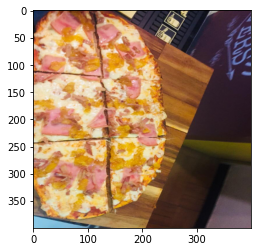

In [11]:
import matplotlib.pyplot as plt
plt.imshow(X_train[1].reshape((400, 400, 3)))
plt.show()

# Clasificación de imagenes utilizando utilizando `sklearn`

Para esto utilizaremos los 3 modelos propuestos en clase:

1. Regresión Logistica
2. Random Forest
3. GradientBoosting

## Modelo 1 - Regresión Logistica

In [41]:
model_rgl=LogisticRegression()                   # Instanciamos el modelo de regresión    
model_rgl.fit(X_train,y_train)                   # Entrenamos el modelo con valores por defecto

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [43]:
# Desempeño en accuracy entrenamiento

print('El desempeño de la regresion en train es de', accuracy_score(y_train, model_rgl.predict(X_train)))

# Desempeño en val
print('El desempeño de la regresion en validacion es de', accuracy_score(y_val, model_rgl.predict(X_val)))

# Desempeño en test 
print('El desempeño de la regresion en test es de', accuracy_score(y_test, model_rgl.predict(X_test)))

El desempeño de la regresion en train es de 1.0
El desempeño de la regresion en validacion es de 0.5882352941176471
El desempeño de la regresion en test es de 0.6470588235294118


In [0]:



#  Calculamos las predicciones de las probabilidades del dataset de test
y_pred_prob = model.predict_proba(X_val)[:,1]

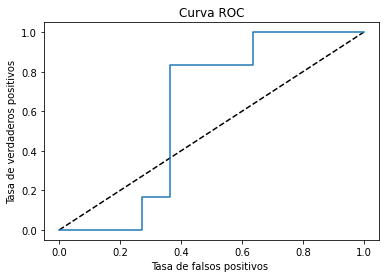

In [21]:
# Generamos los valores necesario para la curva roc
fpr, tpr, thresholds = roc_curve(y_val, y_pred_prob) # Primero los datos reales y luegos los pronosticados por el modelo

# Graficamos curva ROC
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('Tasa de falsos positivos ')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva ROC')
plt.show()

In [0]:
grid={"C":np.logspace(-3,3,7),               
      "penalty":["l1","l2"]}

model=GridSearchCV(model,grid,cv=5, scoring = 'accuracy')

In [0]:
model.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

## Modelo 2 - Random Forest

In [22]:
random_forest = RandomForestClassifier(n_estimators=100, max_depth=5) # Instanciamos el modelo con 100 arboles y 5 de profundidad

random_forest.fit(X_train, y_train)                                    # Entrenamos el modelo

El desempeño del random en train es de 1.0
El desempeño del random en validacion es de 0.47058823529411764
El desempeño del random en test es de 0.6470588235294118


Imprimimos metrica de accuracy inicial. Luego veremos otras métricas

In [0]:
# Desempeño en accuracy entrenamiento
print('El desempeño del random en train es de', accuracy_score(y_train, random_forest.predict(X_train)))

# Desempeño en val
print('El desempeño del random en validacion es de', accuracy_score(y_val, random_forest.predict(X_val)))

# Desempeño en test 
print('El desempeño del random en test es de', accuracy_score(y_test, random_forest.predict(X_test)))

In [25]:
# Observemos algunas metricas mas adecuadas para clasificacion binaria
print(classification_report(y_val, random_forest.predict(X_val)))             # Revisamos metricas

              precision    recall  f1-score   support

           0       0.58      0.64      0.61        11
           1       0.20      0.17      0.18         6

    accuracy                           0.47        17
   macro avg       0.39      0.40      0.40        17
weighted avg       0.45      0.47      0.46        17



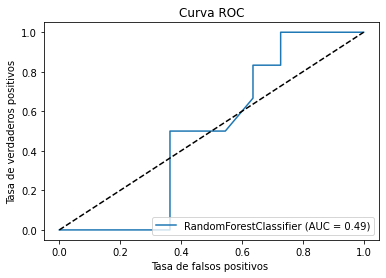

In [28]:
# Graficamos curva ROC
plot_roc_curve(random_forest, X_val, y_val)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Tasa de falsos positivos ')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva ROC')
plt.show()
plt.show()

**Vamos a realizar una optimización de hipeparametros**

Establecemos los valores de los hiperparametros de busqueda del RandomForest

In [0]:
param_grid = {'n_estimators': [150,250,300],    # Aumentamos el numero de estimadores
              'max_features': ['sqrt', 'log2'], # Intetamos reducir el numero de features a traves de estas funciones  
              'max_depth':[5,8,10],
              'criterion':['gini', 'entropy']}

model_rf = GridSearchCV(estimator=random_forest, 
                        param_grid=param_grid, cv= 5, scoring = 'accuracy',
                        n_jobs=-1)

In [37]:
model_rf.fit(X_train, y_train)                  # Ajustamos y optimzamos hiperparametros con el conjunto de train 

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=5,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              random_s

In [38]:
model_rf.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=5, max_features='log2',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=250,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

Vamos a revisar nuevamente el accurary y las metricas de precision, recall y f1-score luego de realizar la optimización de hiperparametros

In [39]:
# Desempeño en accuracy entrenamiento
print('El desempeño del random en train es de', accuracy_score(y_train, model_rf.predict(X_train)))

# Desempeño en val
print('El desempeño del random en validacion es de', accuracy_score(y_val, model_rf.predict(X_val)))

# Desempeño en test 
print('El desempeño del random en test es de', accuracy_score(y_test, model_rf.predict(X_test)))

El desempeño del random en train es de 1.0
El desempeño del random en validacion es de 0.5294117647058824
El desempeño del random en test es de 0.7058823529411765


In [40]:
# Precision, recall y f1-scores en validation
print(classification_report(y_val, model_rf.predict(X_val))) 

              precision    recall  f1-score   support

           0       0.60      0.82      0.69        11
           1       0.00      0.00      0.00         6

    accuracy                           0.53        17
   macro avg       0.30      0.41      0.35        17
weighted avg       0.39      0.53      0.45        17



In [0]:
# Pendiente entrenar con train + validation y testear

## Modelo 3 - Gradient Boosting

In [0]:
def iterarmodelos(d2_train_dataset,y,modelo='rf',testsize=0.2):
  
  X_train, X_test, y_train, y_test = train_test_split(d2_train_dataset, y, test_size=testsize, random_state=42,stratify=y)
  
  if modelo == 'rf':
    model=RandomForestClassifier()
    # param_grid = {'n_estimators': [100,200,500],'max_features': ['auto', 'sqrt', 'log2'],'max_depth':[4,5,6,7,8],'criterion':['gini', 'entropy']}
    # model= GridSearchCV(estimator=model, param_grid=param_grid, cv= 5, scoring = 'accuracy')
  elif modelo=='sv':
    model=SVC()
    # tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],                     'C': [1, 10, 100, 1000]},                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]
    # model= GridSearchCV(estimator=model, param_grid=tuned_parameters, cv= 5)
  elif modelo=='dt':
    model=DecisionTreeClassifier()
    # parameters={'min_samples_split' : range(10,500,20),'max_depth': range(1,20,2)}
    # model=grid_search.GridSearchCV(model,parameters,cv=5, scoring = 'accuracy')
  elif modelo=='gb':
    model=GradientBoostingClassifier()
    # parameters = {"loss":["deviance"],    "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],    "min_samples_split": np.linspace(0.1, 0.5, 12),    "min_samples_leaf": np.linspace(0.1, 0.5, 12),    "max_depth":[3,5,8],    "max_features":["log2","sqrt"],    "criterion": ["friedman_mse",  "mae"],    "subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],    "n_estimators":[10]    }
    # model = GridSearchCV(model, parameters, cv=5, n_jobs=-1)
  elif modelo=='rl':

  elif modelo=='kn':
    model=KNeighborsClassifier()
    # param_grid = dict(n_neighbors = k_range, weights = weight_options)
    # model = GridSearchCV(model, param_grid, cv = 5, scoring = 'accuracy')
  else:
    print('la función no está entrenada para este algoritmo')



In [0]:
def iterarmodelos(x_resh,y,modelo='rf',testsize=0.2):
  
  X_train, X_val1, y_train, y_val1 = train_test_split(x_resh, y,
                                                    stratify=y, 
                                                    test_size=0.40,  random_state = 42)


  X_val, X_test, y_val, y_test = train_test_split(X_val1, y_val1,
                                                    stratify=y_val1, 
                                                    test_size=0.5,  random_state = 42)
  
  if modelo == 'rf':
    model=RandomForestClassifier()
    # param_grid = {'n_estimators': [100,200,500],'max_features': ['auto', 'sqrt', 'log2'],'max_depth':[4,5,6,7,8],'criterion':['gini', 'entropy']}
    # model= GridSearchCV(estimator=model, param_grid=param_grid, cv= 5, scoring = 'accuracy')
  elif modelo=='sv':
    model=SVC()
    # tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],                     'C': [1, 10, 100, 1000]},                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]
    # model= GridSearchCV(estimator=model, param_grid=tuned_parameters, cv= 5)
  elif modelo=='dt':
    model=DecisionTreeClassifier()
    # parameters={'min_samples_split' : range(10,500,20),'max_depth': range(1,20,2)}
    # model=grid_search.GridSearchCV(model,parameters,cv=5, scoring = 'accuracy')
  elif modelo=='gb':
    model=GradientBoostingClassifier()
    # parameters = {"loss":["deviance"],    "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],    "min_samples_split": np.linspace(0.1, 0.5, 12),    "min_samples_leaf": np.linspace(0.1, 0.5, 12),    "max_depth":[3,5,8],    "max_features":["log2","sqrt"],    "criterion": ["friedman_mse",  "mae"],    "subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],    "n_estimators":[10]    }
    # model = GridSearchCV(model, parameters, cv=5, n_jobs=-1)
  elif modelo=='rl':
    model=LogisticRegression()
    grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}
    model=GridSearchCV(model,grid,cv=5, scoring = 'accuracy')
  elif modelo=='kn':
    model=KNeighborsClassifier()
    # param_grid = dict(n_neighbors = k_range, weights = weight_options)
    # model = GridSearchCV(model, param_grid, cv = 5, scoring = 'accuracy')
  else:
    print('la función no está entrenada para este algoritmo')

  model.fit(X_train,y_train)
  print(accuracy_score(y_val,model.predict(X_val)))
  return confusion_matrix(y_val,model.predict(X_val))

In [0]:
iterarmodelos(x_resh,y,modelo='gb')

0.6


array([[4, 2],
       [2, 2]])

In [0]:
iterarmodelos(x_resh,y,modelo='rl')

0.8


array([[6, 0],
       [2, 2]])